In [1]:
library(tokenizers)
library(stringr)
library(neuralnet)
library(testthat)
options(warn=-1)

## The Word2Vec model of semantic memory

In the tutorial this week, we will focus on the word2vec model of semantic memory. Word2vec takes a corpus of text and generates semantic vectors (or embeddings) for each of the tokens (words and punctuation marks) in the text. Semantically similar words tend to be represented by similar vectors.

Typically, one would apply word2vec to very large corpora - in the hundreds of millions or billions of words. These can take a long time to train, so for the purposes of demonstration, we will use much smaller texts. Note that more text will further improve the vectors' ability to capture the meanings of the words.

I have chosen a short passage from the classic "Dick and Jane" readers for kids called "Something Pretty". The text is quite repetitive (and dated!), so contexts repeat quite often even though the text is short - allowing the model to find commonalities which would typically require a much larger corpus to see. 

The first step is to turn the raw text into a series of tokens. A function that does this is called a tokenizer. R has several tokenizers available in the tokenizers package. Unfortunately none of them are very good. Below we use the Penn Tree Bank tokenizer (called tokenize_ptb). Sometimes it has trouble separating full stops from words and stuggles with quotation marks in the text, so I have provided some assistance by putting spaces around the full stops and removing the quotation marks. Note we make the text lower case, so the model treats words as the same regardless of the captialisation. 

In [2]:
text = "Mother said Look look . See this .
Oh oh said Sally .  It is pretty .
Yes yes said Jane .  Mother looks pretty .
Look Sally said Jane .
Here is something pretty . Something pretty for you and me .
Oh Jane  said Sally .  I want something . I want something red . I want something blue .
I want this said Jane . And this and this . Three for me . Three for you . Something yellow . Something red . Something blue ."

corpus = tokenize_ptb(tolower(text))
corpus
T = length(corpus[[1]])
print(paste0("corpus size = ", T))



[[1]]
 [1] "mother"    "said"      "look"      "look"      "."         "see"      
 [7] "this"      "."         "oh"        "oh"        "said"      "sally"    
[13] "."         "it"        "is"        "pretty"    "."         "yes"      
[19] "yes"       "said"      "jane"      "."         "mother"    "looks"    
[25] "pretty"    "."         "look"      "sally"     "said"      "jane"     
[31] "."         "here"      "is"        "something" "pretty"    "."        
[37] "something" "pretty"    "for"       "you"       "and"       "me"       
[43] "."         "oh"        "jane"      "said"      "sally"     "."        
[49] "i"         "want"      "something" "."         "i"         "want"     
[55] "something" "red"       "."         "i"         "want"      "something"
[61] "blue"      "."         "i"         "want"      "this"      "said"     
[67] "jane"      "."         "and"       "this"      "and"       "this"     
[73] "."         "three"     "for"       "me"        "."         "three"    
[79] "for"       "you"       "."         "something" "yellow"    "."        
[85] "something" "red"       "."         "something" "blue"      "."

[1] "corpus size = 90"


The input and output vectors for word2vec use one hot coding. That means that each word corresponds to one dimension in the vector. To represent a word, we set the value of the that dimension to 1 and the values of all of the other dimensions to 0. Even though a word may appear many times in the corpus, its dimension will be the same each time.

For instance, if the word "blue" is assigned to dimension 3, the vector representing "blue" will be:

00100000000000000000000000

In the next cell, we create "vocab" which is a list of the unique tokens and "I" which maps tokens to unique dimensions. 

In [3]:
vocab = unique(str_sort(corpus[[1]]))
V = length(vocab)
I = 1:V
names(I) = vocab

print(paste0("vocabulary size = ", V))
vocab
print ("the dimension for blue is")
I[["blue"]]

[1] "vocabulary size = 26"


[1] "."         "and"       "blue"      "for"       "here"      "i"        
 [7] "is"        "it"        "jane"      "look"      "looks"     "me"       
[13] "mother"    "oh"        "pretty"    "red"       "said"      "sally"    
[19] "see"       "something" "this"      "three"     "want"      "yellow"   
[25] "yes"       "you"

[1] "the dimension for blue is"


[1] 3

Now we can create the dataframe that contains our patterns in preparation for training the neural network. We slide a window across the text. The token that appears in the middle of the window is the target and the words on either side are the context tokens. 

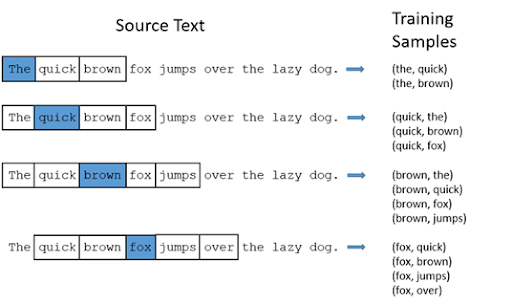

For this very short corpus, we will use a context size of 1, that is, we will just consider the token immediately before the target and immediately after. With larger corpora, we would typically use larger context windows. 

Take a moment to look at the sequence of patterns produced. The code prints out the (context, target) pairs it is encoding as well as the dataframe that the network will use for training. 

In [4]:
contextvars = NULL
targetvars = NULL
for (i in 1:V){
    contextvars = c(contextvars, paste0(vocab[i], "C"))
    }
for (i in 1:V){
    targetvars = c(targetvars, paste0(vocab[i], "T"))
    }

C = 1 # context size
df = data.frame(matrix(0, T, V*2))

colnames(df) = c(contextvars, targetvars)

for (i in 1:T){
    target = corpus[[1]][i]
    df[i, I[[target]]+V] = 1
    context_words = NULL
    for (j in (i-C):(i+C)){
        if (j >= 1 && j <= T && i != j){
            context = corpus[[1]][j]
            context_words = c(context_words, context)
            df[i, I[[context]]] = 1
        }
    }
    print (paste0(c("Target:", target, "Context:", context_words)))
}

targetvars = paste(targetvars, collapse="+")
contextvars = paste(contextvars, collapse="+")
df



[1] "Target:"  "mother"   "Context:" "said"    
[1] "Target:"  "said"     "Context:" "mother"   "look"    
[1] "Target:"  "look"     "Context:" "said"     "look"    
[1] "Target:"  "look"     "Context:" "look"     "."       
[1] "Target:"  "."        "Context:" "look"     "see"     
[1] "Target:"  "see"      "Context:" "."        "this"    
[1] "Target:"  "this"     "Context:" "see"      "."       
[1] "Target:"  "."        "Context:" "this"     "oh"      
[1] "Target:"  "oh"       "Context:" "."        "oh"      
[1] "Target:"  "oh"       "Context:" "oh"       "said"    
[1] "Target:"  "said"     "Context:" "oh"       "sally"   
[1] "Target:"  "sally"    "Context:" "said"     "."       
[1] "Target:"  "."        "Context:" "sally"    "it"      
[1] "Target:"  "it"       "Context:" "."        "is"      
[1] "Target:"  "is"       "Context:" "it"       "pretty"  
[1] "Target:"  "pretty"   "Context:" "is"       "."       
[1] "Target:"  "."        "Context:" "pretty"   "yes"     
[1] "Tar

.C,andC,blueC,forC,hereC,iC,isC,itC,janeC,lookC,⋯,saidT,sallyT,seeT,somethingT,thisT,threeT,wantT,yellowT,yesT,youT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,1,⋯,1,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,⋯,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Recall that the word2vec model can be trained in two ways. The Continuous Bag of Words (CBoW) model uses the context to predict the target token, while the skipgram model uses the target to predict the context. 

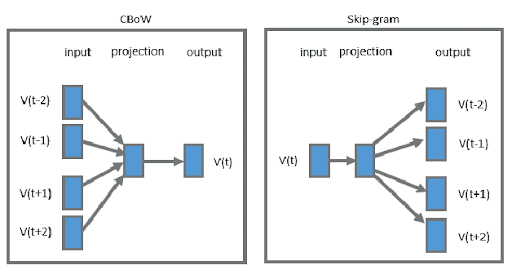

We will start with the CBoW model - so our formula for the neural network will be "targetvars ~ contextvars".


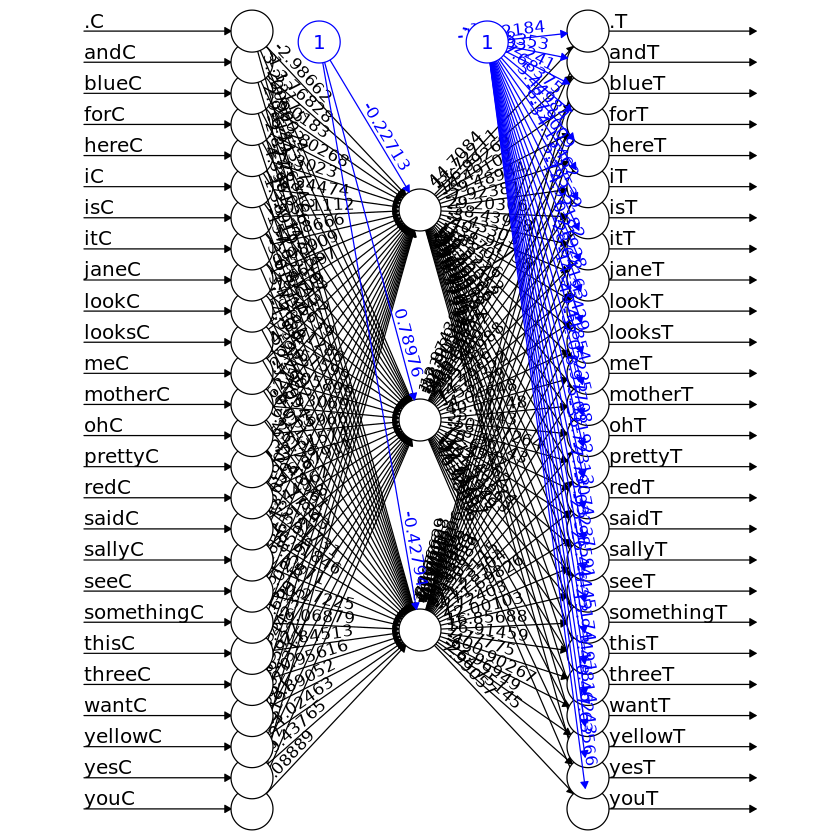

In [5]:
strformula = paste(targetvars, "~", contextvars)
NumHidden = 3
set.seed(6)
nn = neuralnet(as.formula(strformula), data=df, hidden=NumHidden, act.fct="logistic", linear.output=FALSE)
plot(nn, rep="best")

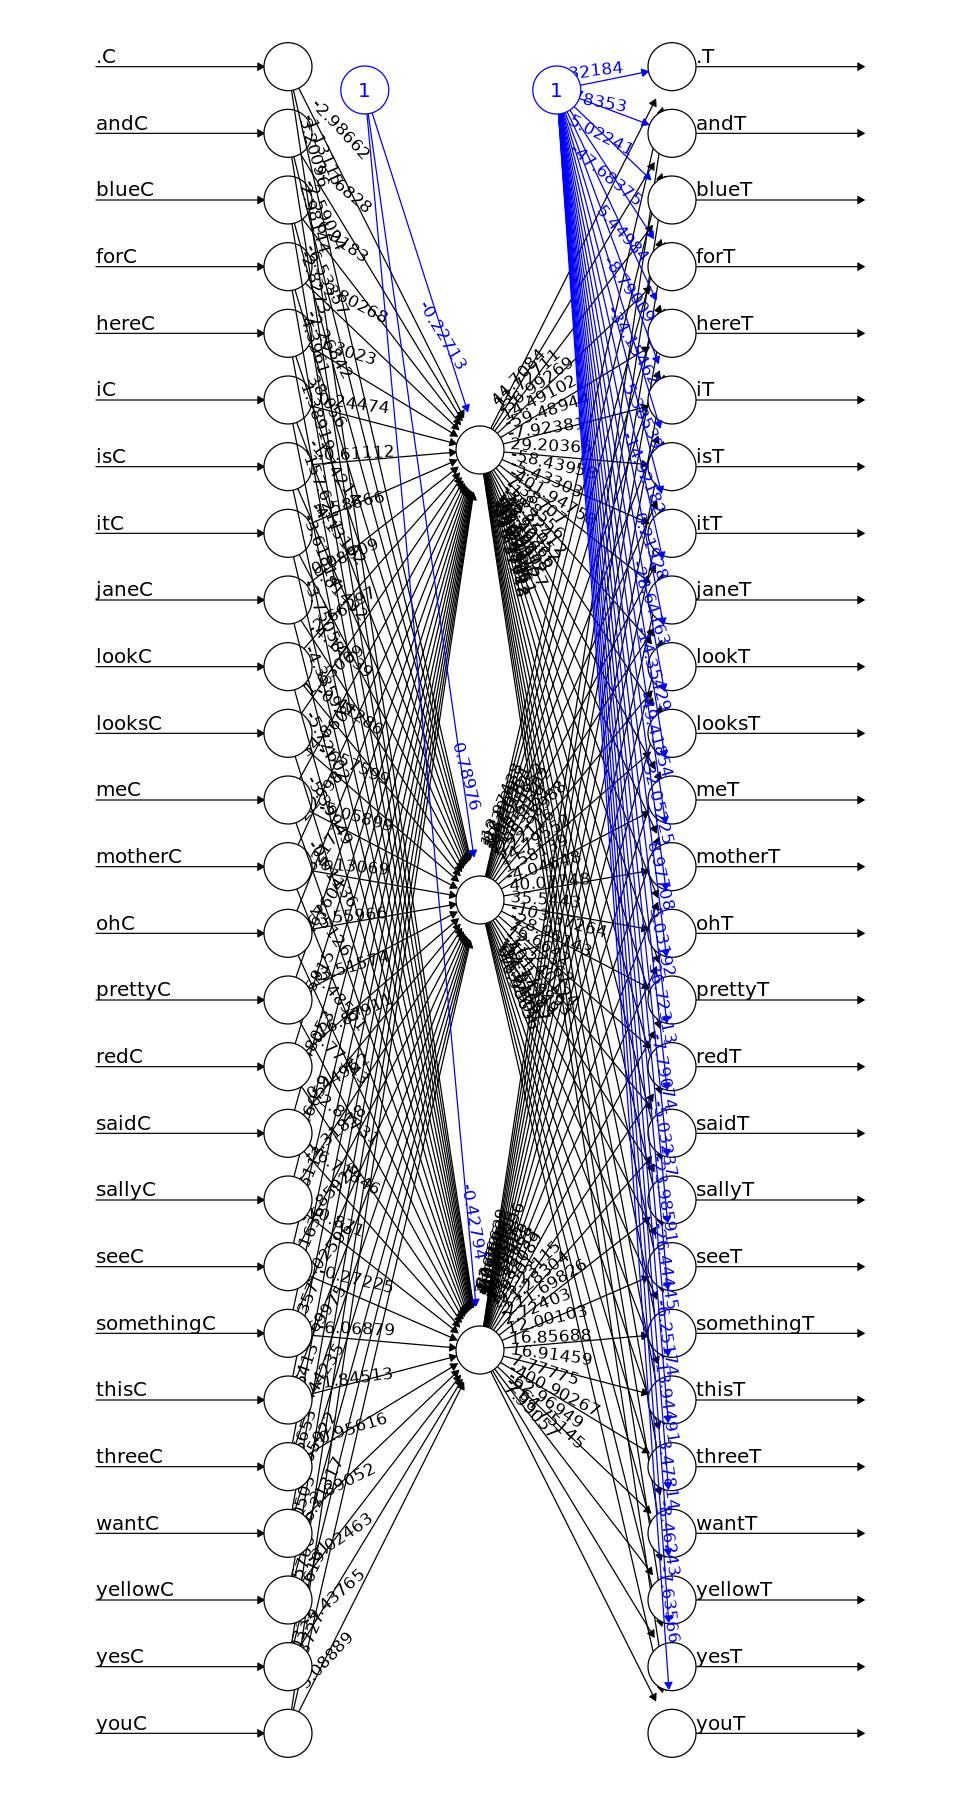

In [8]:
strformula = paste(targetvars, "~", contextvars)
NumHidden = 3
set.seed(6)
nn = neuralnet(as.formula(strformula), data=df, hidden=NumHidden, act.fct="logistic", linear.output=FALSE)
plot(nn, rep="best")

One convenient way to visualize the token embeddings produced by the model is to generate the hierarachical cluster diagram of the weights. Hierarchical cluster analysis creates a tree in which the most similar patterns are connected at the lower levels of the tree. Below we have taken the final weights from each target token in the output from each of the hidden units. Each word is represented by a vector of three numbers. Then we apply hierarchical cluster analysis to see which tokens the model thinks are most similar. 

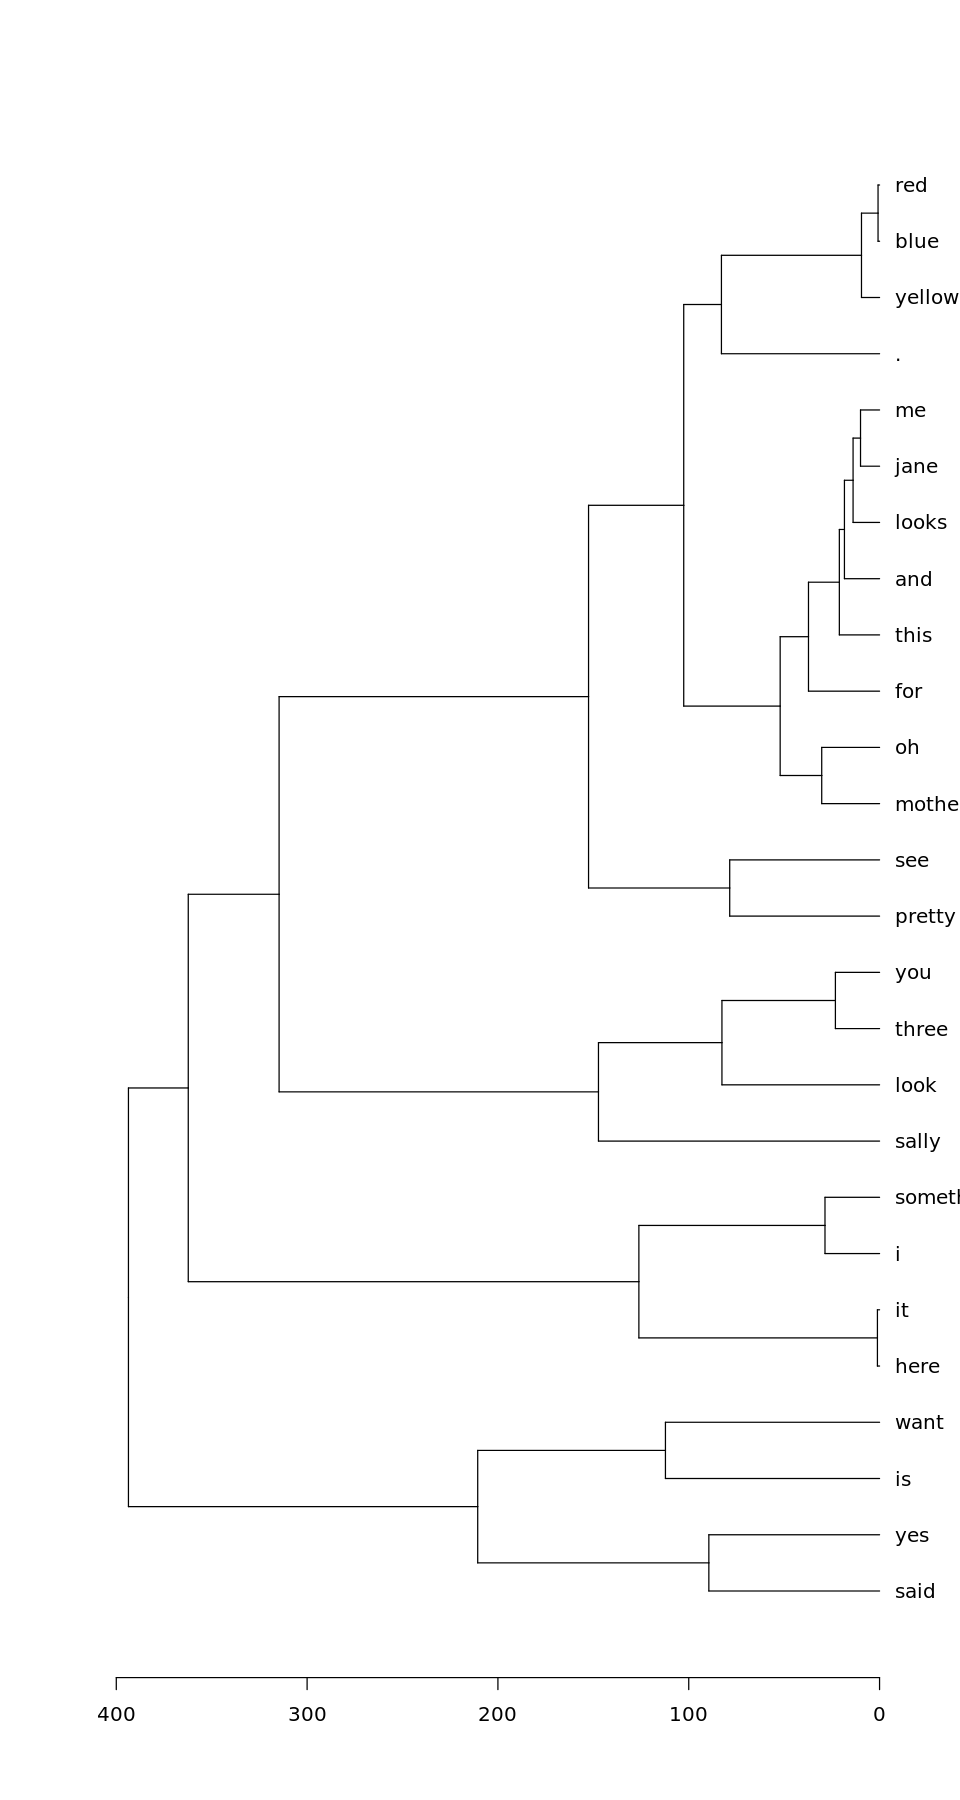

In [9]:

ws = data.frame(t(nn$weights[[1]][[2]][2:(NumHidden+1), 1:V]))
rownames(ws) = vocab
options(repr.plot.width=8, repr.plot.height=15)
dist_mat <- dist(ws, method = 'euclidean')
hclust_avg <- hclust(dist_mat, method = 'average')
plot(as.dendrogram(hclust_avg), horiz=TRUE)

## Exercise 1

Does the hierarchical cluster analysis match your intuitions? Do tokens that mean similar things appear together?

YOUR ANSWER HERE

OK, now lets try the skip gram model. This time, we will use the target tokens to predict the context tokens. 
So, our formula is contextvars ~ targetvars. 

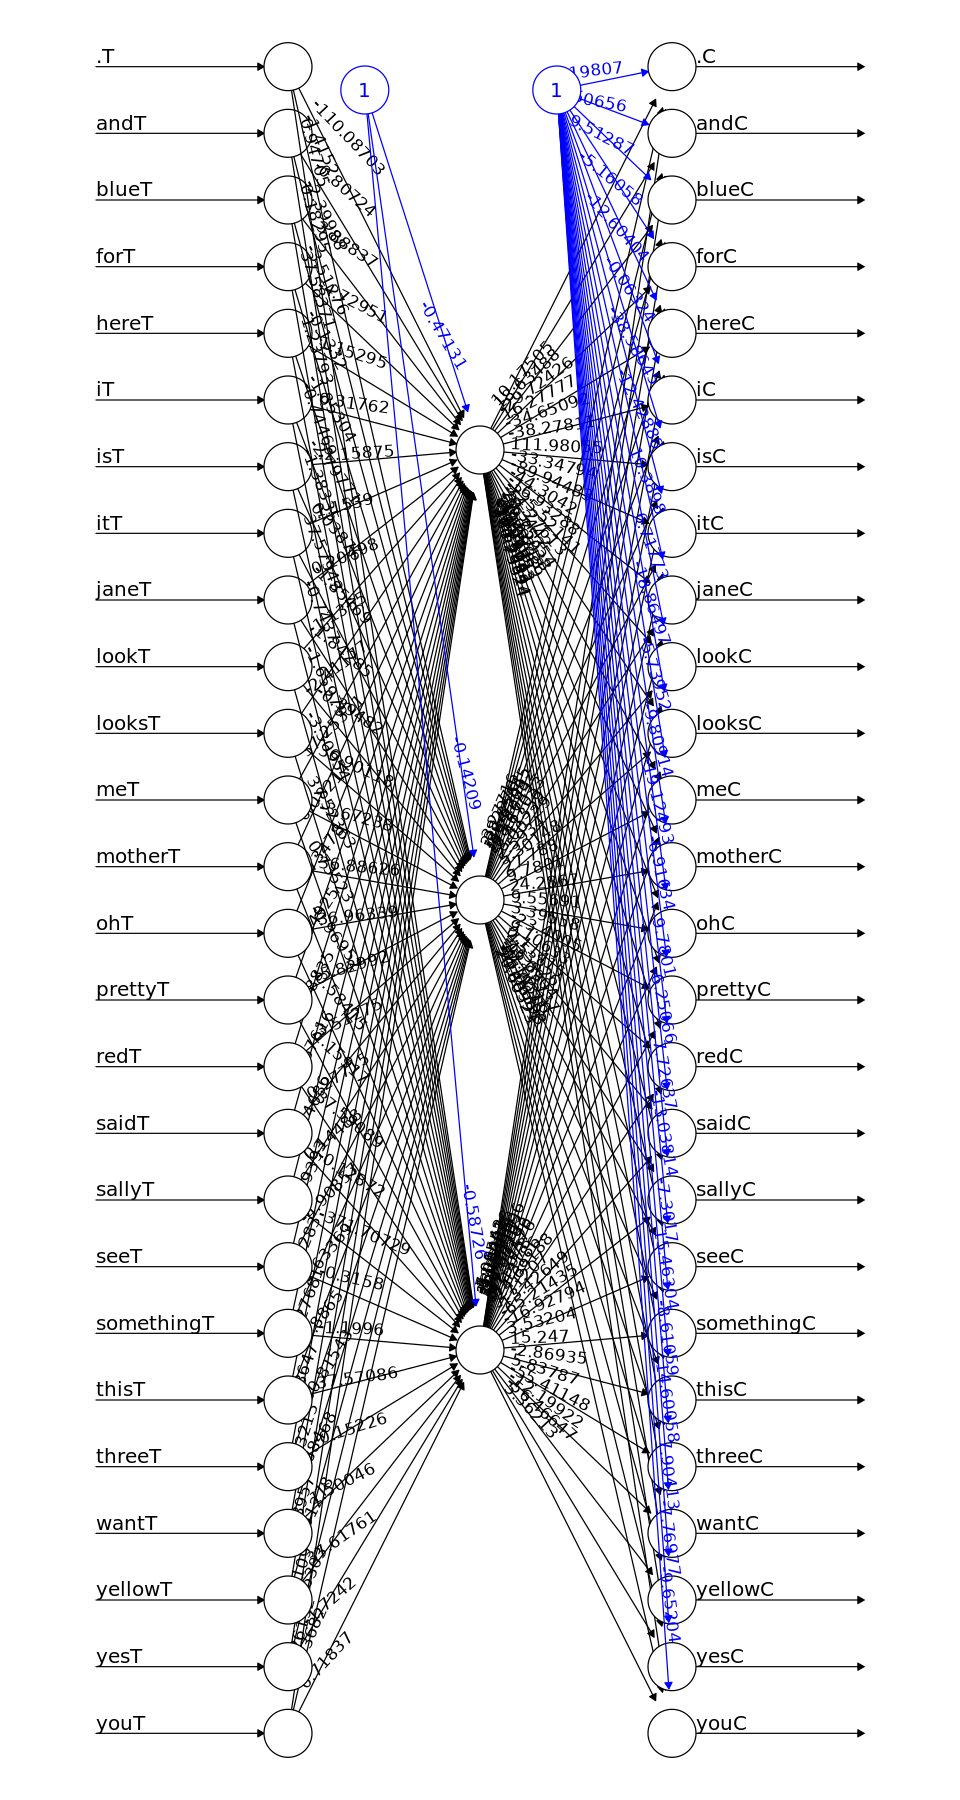

In [10]:
strformula = paste(contextvars, "~", targetvars)
set.seed(6)
nn = neuralnet(as.formula(strformula), data=df, hidden=NumHidden, act.fct="logistic", linear.output=FALSE)
plot(nn, rep="best")

And now we can plot the hierachical cluster diagram. Note this time we are interested in the weights that go from the input layer to the hidden layer because the targets are in the input layer. 

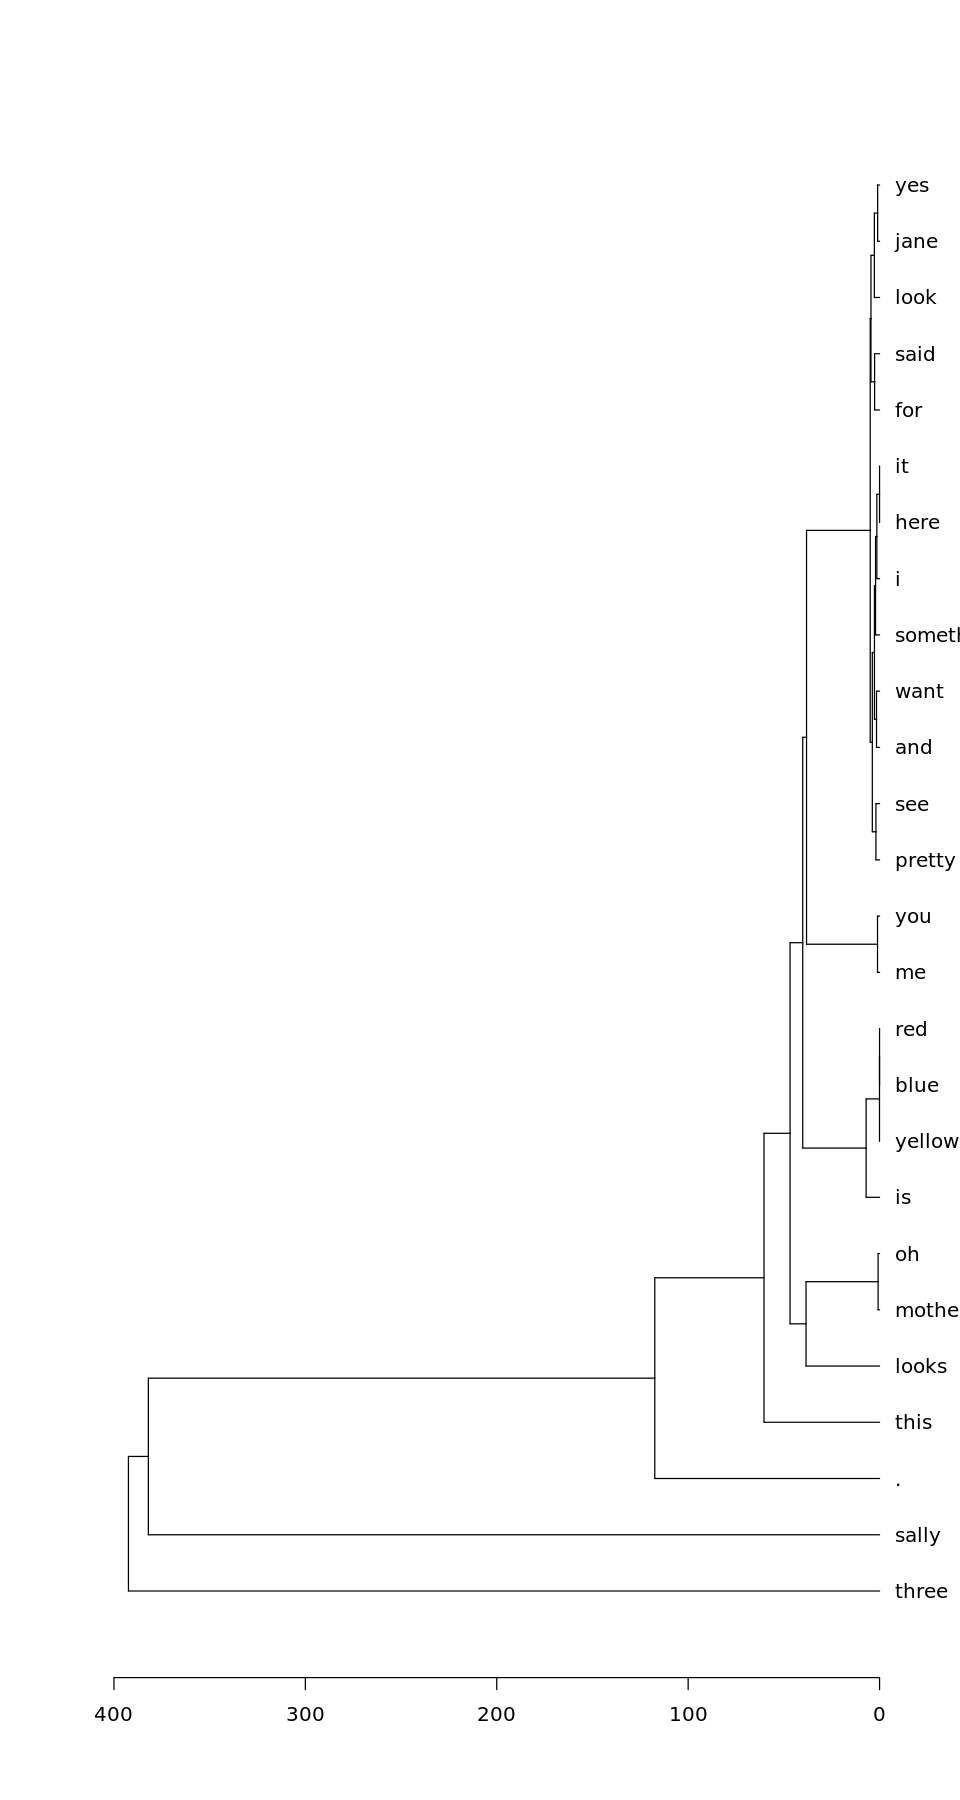

In [11]:
ws = data.frame(nn$weights[[1]][[1]][2:(V+1),1:NumHidden])
rownames(ws) = vocab
options(repr.plot.width=8, repr.plot.height=15)
dist_mat <- dist(ws, method = 'euclidean')
hclust_avg <- hclust(dist_mat, method = 'average')
plot(as.dendrogram(hclust_avg), horiz=TRUE)


## Exercise 2

Does this look better or worse than the CBoW embeddings?

YOUR ANSWER HERE

Sometimes the CBoW model works better and sometimes the skipgram model is superior. The results presented by Mikolov et al. (2013) suggest that CBoW might be better at capturing syntactic class information while the skip gram presentation might be better at capturing semantic information. In general though, one should employ larger corpora and larger models before drawing any conclusions. In the assignment, we will try a somewhat larger network.